# Computing the Mandelbrot set with Python, Cython and C

The Mandelbrot set is defined as the set of complex numbers $c$ that does not diverge when iterated from $z = 0$ for the function

\begin{align}
    f_c(z) = z^2 + c.
\end{align}

By choosing a value for $c$ and starting with $z = 0$ we can check if the sequence

\begin{align}
    z_{n + 1} = z_{n} + c,
\end{align}

diverges. In our case we do this by checking if

\begin{align}
    \lim_{n \to \infty} |z_{n + 1}| \leq d,
\end{align}

for a given divergence criteria $d$. Due to the finiteness of life, the universe and everything, we limit $n$ by a given number and abort the sequence when $|z_{n + 1}| > d$.

In [1]:
# This line might be needed by some
#%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np
import numba

In [2]:
%%javascript
// Fill entire cell with output
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Adjust the figure size of matplotlib
figsize(20, 14)
# Use Latex rendering of axes
plt.rc('text', usetex=True)

In [4]:
# Define variables for an interesting region of the Mandelbrot set
x_min = -0.835
x_max = -0.830
y_min = 0.209
y_max = 0.211
num_x = 1000
num_y = 1000
#max_iterations = 100
max_iterations = 1000
divergence = 2

args = [x_min, x_max, y_min, y_max, num_x, num_y, max_iterations, divergence]

## Python solution

Let's test a "solution" of the Mandelbrot set using pure Python. Should we do this as an exercise?

In [5]:
def get_mandelbrot_set(x_min, x_max, y_min, y_max, num_x, num_y, max_iterations, divergence):
    mandelbrot_set = [[0 for i in range(num_x)] for j in range(num_y)]
    
    assert num_x > 1 and num_y > 1

    dx = abs(x_max - x_min)/float(num_x - 1)
    dy = abs(y_max - y_min)/float(num_y - 1)
    
    for j in tqdm(range(num_y)):
        for i in range(num_x):
            c = complex(x_min + i*dx, y_min + j*dy)
            z = complex(0, 0)
            for k in range(max_iterations):
                z = z**2 + c

                if abs(z) > divergence:
                    break

                mandelbrot_set[j][i] = k + 1

    return mandelbrot_set

In [6]:
time1 = time.time()
mandelbrot_set = get_mandelbrot_set(*args)
time2 = time.time()

print ("Python solution took {0:.02f} seconds".format(time2 - time1))

100%|██████████| 1000/1000 [00:44<00:00, 22.67it/s]

Python solution took 44.20 seconds


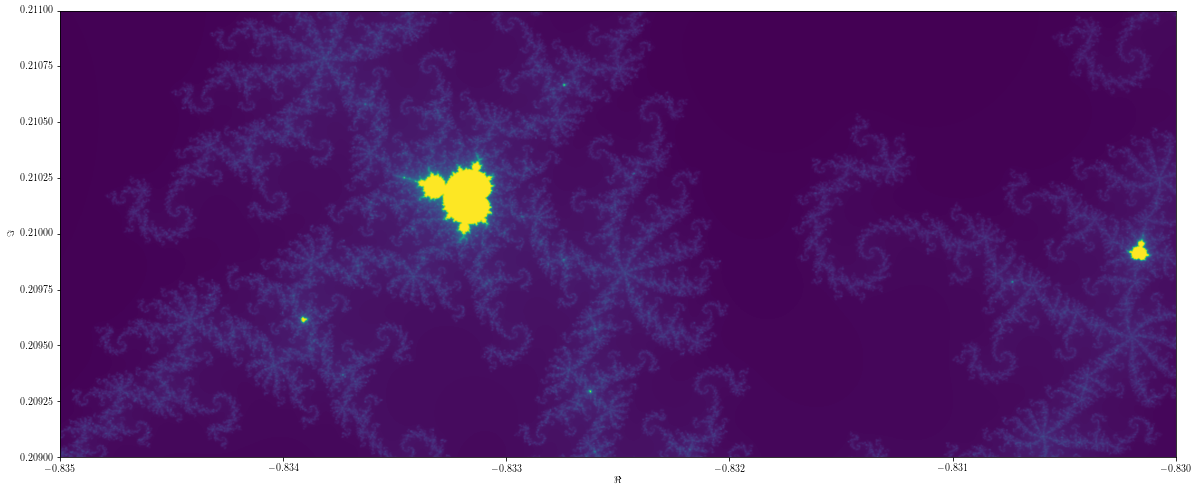

In [7]:
plt.imshow(
    mandelbrot_set, extent=[x_min, x_max, y_min, y_max], origin="lower", interpolation="bicubic")
plt.xlabel(r"$\Re$")
plt.ylabel(r"$\Im$")
plt.show()

Hmmm, that takes quite some time. Can we do better?

Enter __Numpy__!
Exercise?

## Numpy improvement

By using vectorization we should in theory gain a massive speed-up! Let's give it a go!

In [8]:
def get_mandelbrot_set(x_min, x_max, y_min, y_max, num_x, num_y, max_iterations, divergence):
    c_imag, c_real = np.ogrid[y_min:y_max:num_y*1j, x_min:x_max:num_x*1j]
    c = (c_real + 1j*c_imag).astype(np.complex64)
    z = np.zeros_like(c)
    mandelbrot_set = np.zeros(z.shape, dtype=int)
    
    for k in tqdm(range(max_iterations)):
        indices = np.abs(z) <= divergence
        z[indices] = z[indices]**2 + c[indices]
        mandelbrot_set[indices] = k + 1

    return mandelbrot_set

In [9]:
time1 = time.time()
mandelbrot_set = get_mandelbrot_set(*args)
time2 = time.time()

print ("Numpy solution took {0:.02f} seconds".format(time2 - time1))

100%|██████████| 1000/1000 [00:10<00:00, 95.47it/s]

Numpy solution took 10.50 seconds


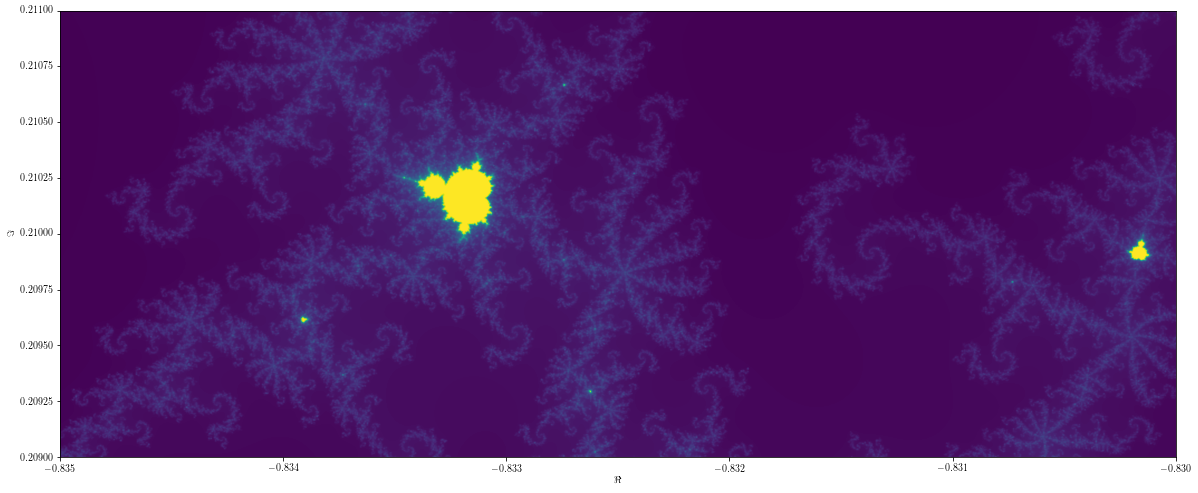

In [10]:
plt.imshow(
    mandelbrot_set, extent=[x_min, x_max, y_min, y_max], origin="lower", interpolation="bicubic")
plt.xlabel(r"$\Re$")
plt.ylabel(r"$\Im$")
plt.show()

Hurrah! Massive improvement! High five for everyone! :D

## The juicy stuff

Can we go completely crazy? Turns out, we can!

In [11]:
# Run the C-code of the Mandelbrot set
from compute_mandelbrot import get_mandelbrot_set

In [12]:
time1 = time.time()
mandelbrot_set = get_mandelbrot_set(*args)
time2 = time.time()

print ("C and Cython solution took {0:.02f} seconds".format(time2 - time1))

C and Cython solution took 0.47 seconds


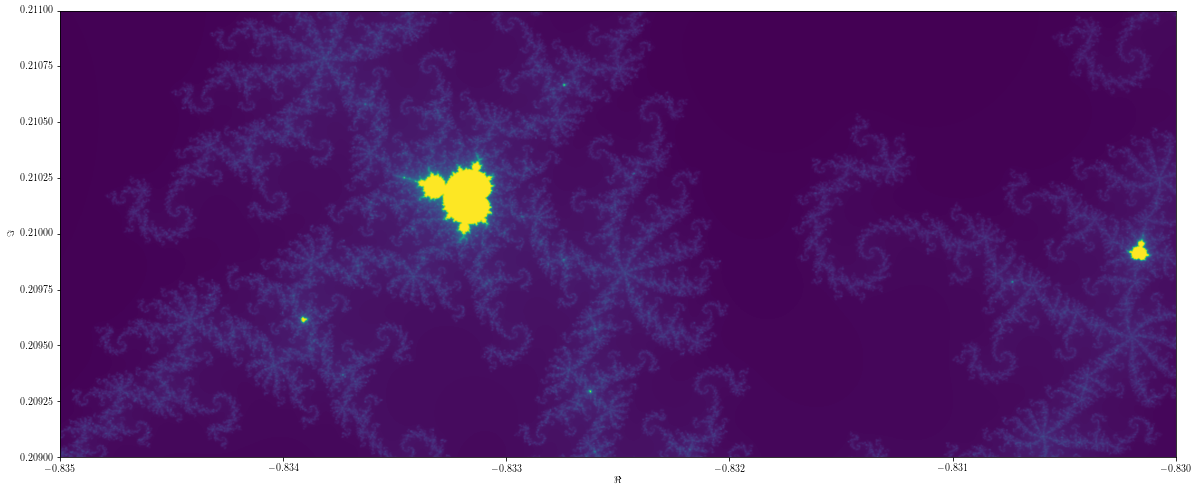

In [13]:
plt.imshow(
    mandelbrot_set, extent=[x_min, x_max, y_min, y_max], origin="lower", interpolation="bicubic")
plt.xlabel(r"$\Re$")
plt.ylabel(r"$\Im$")
plt.show()

In [14]:
# Add better resolution for the C-code
num_x = 2000
num_y = 2000
max_iterations = 400

args = [x_min, x_max, y_min, y_max, num_x, num_y, max_iterations, divergence]

time1 = time.time()
mandelbrot_set = get_mandelbrot_set(x_min, x_max, y_min, y_max, num_x, num_y, max_iterations, divergence)
time2 = time.time()
print ("C and Cython solution took {0:.02f} seconds".format(time2 - time1))

C and Cython solution took 1.73 seconds


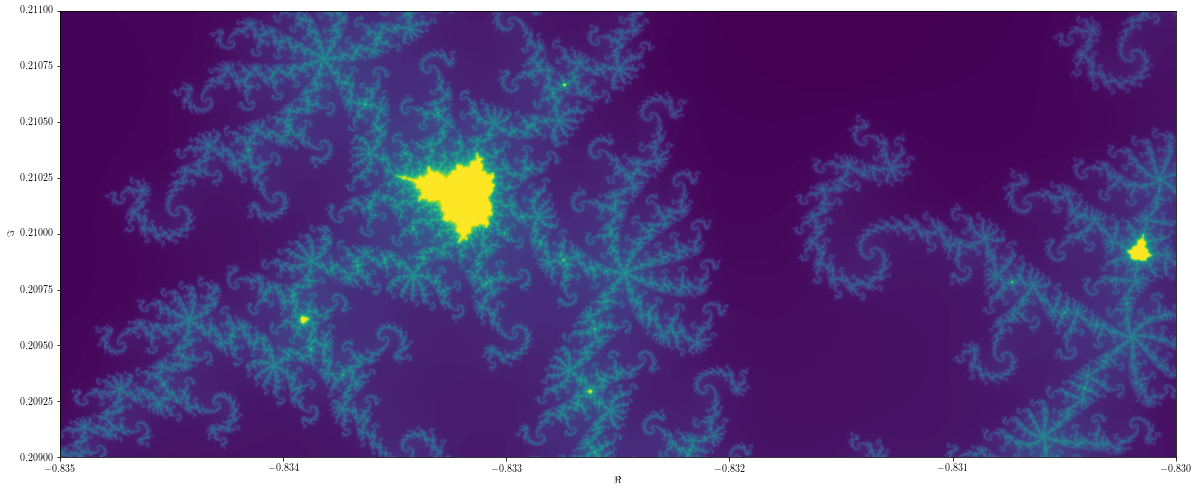

In [15]:
plt.imshow(
    mandelbrot_set, extent=[x_min, x_max, y_min, y_max], origin="lower", interpolation="bicubic")
plt.xlabel(r"$\Re$")
plt.ylabel(r"$\Im$")
plt.show()

## Bonus: Numba

Can we achieve C-like speed while retaining the power of laziness? Let's try Numba!

In [16]:
@numba.njit
def get_mandelbrot_set(x_min, x_max, y_min, y_max, num_x, num_y, max_iterations, divergence):
    mandelbrot_set = np.zeros((num_y, num_x))
    
    assert num_x > 1 and num_y > 1

    dx = abs(x_max - x_min)/float(num_x - 1)
    dy = abs(y_max - y_min)/float(num_y - 1)
    
    for j in range(num_y):
        for i in range(num_x):
            c = complex(x_min + i*dx, y_min + j*dy)
            z = complex(0, 0)
            for k in range(max_iterations):
                z = z**2 + c

                if abs(z) > divergence:
                    break

                mandelbrot_set[j][i] = k + 1

    return mandelbrot_set

In [17]:
time1 = time.time()
mandelbrot_set = get_mandelbrot_set(*args)
time2 = time.time()

print ("Numba solution took {0:.02f} seconds".format(time2 - time1))

Numba solution took 2.97 seconds


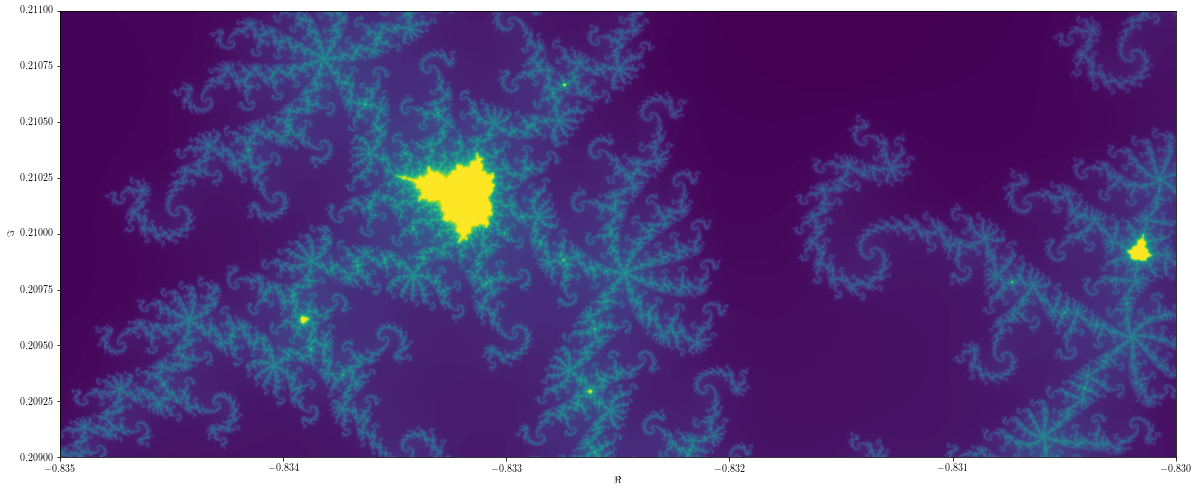

In [18]:
plt.imshow(
    mandelbrot_set, extent=[x_min, x_max, y_min, y_max], origin="lower", interpolation="bicubic")
plt.xlabel(r"$\Re$")
plt.ylabel(r"$\Im$")
plt.show()

## Conclusion

Not surprisingly, the C-solution is by far the fastest way to compute the Mandelbrot set. But, as far as programming convenience goes and the gain in speed-up, Numba takes the cake!